     |████████████████████████████████| 71kB 5.4MB/s 
2.5.0
Running on CoLab
Mounted at /content/drive/
driveDir :drive/MyDrive/LocalDrive
timestr:20210613-220459
name:movie_Year2019_256_256_100_20210613-220459
sessionCheckpointFile:drive/MyDrive/LocalDrive/Golden/Running/checkpoints/movie_Year2019_256_256_100_20210613-220459/cp-{epoch:04d}.ckpt
sessionCheckpointDir:drive/MyDrive/LocalDrive/Golden/Running/checkpoints/movie_Year2019_256_256_100_20210613-220459
mkdir:drive/MyDrive/LocalDrive/Golden/Running/checkpoints/movie_Year2019_256_256_100_20210613-220459
sessionModelDir:drive/MyDrive/LocalDrive/Golden/Running/models/movie_Year2019_256_256_100_20210613-220459
mkdir:drive/MyDrive/LocalDrive/Golden/Running/models/movie_Year2019_256_256_100_20210613-220459
sessionModelFile:drive/MyDrive/LocalDrive/Golden/Running/models/movie_Year2019_256_256_100_20210613-220459/model.h5
sessionBestModelFile:drive/MyDrive/LocalDrive/Golden/Running/models/movie_Year2019_256_256_100_20210613-220459/Year20

  0%|          | 0/3525 [00:00<?, ?it/s]

data.head():           Id                                      Genre  ... War  Western
0  tt5363618                          ['Drama','Music']  ...   0        0
1  tt4154796    ['Action','Adventure','Drama','Sci-Fi']  ...   0        0
2  tt3741700  ['Action','Adventure','Fantasy','Sci-Fi']  ...   0        0
3  tt7131622                         ['Comedy','Drama']  ...   0        0
4  tt6751668              ['Comedy','Drama','Thriller']  ...   0        0

[5 rows x 28 columns]
info.head():           Id                                      Genre SampledType  Compose
0  tt5363618                          ['Drama','Music']           N     4160
1  tt4154796    ['Action','Adventure','Drama','Sci-Fi']           N   262211
2  tt3741700  ['Action','Adventure','Fantasy','Sci-Fi']           N   262403
3  tt7131622                         ['Comedy','Drama']           N       80
4  tt6751668              ['Comedy','Drama','Thriller']           N  2097232
info[id][1] :  tt4154796
classes: Index(['Act

100%|██████████| 3525/3525 [00:43<00:00, 81.30it/s]


images.shape : (3525, 256, 256, 3)
labels.shape :  (3525, 24)
imagesToTrain.shape :  (2996, 256, 256, 3)
labelsToTrain.shape :  (2996, 24)
imagesToTest.shape :  (529, 256, 256, 3)
labelsToTest.shape :  (529, 24)
94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 24)                49176     
Total params: 23,636,888
Trainable params: 23,583,768
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
94/94 [==============================] - 82s 470ms/step - loss: 0.2065 - accuracy: 0.2907 - binary_accuracy: 0.9166 - top_1_categorical_accuracy: 0.2907 - top_3_categorical_accuracy: 0.6469 - top_5_categorical_accuracy: 0.8268 - truepositive: 6593.0000 - truenegative: 59314.0000 - falsepositive: 1945.0000 - falsenegative: 4052.0000 - precision: 0.7722 - val_loss: 18.6363 - val_accuracy: 0.0586 - val_binary_accuracy: 0.8278 - val_top_1_categorical_accuracy: 0.1909 - val_top_3_categorical_accuracy: 0.5369 - val_top_5_categorical_accuracy: 0.7013 - val_truepositive: 388.0000 - val_truenegative: 10122.0000 - val_falsepositive: 684.0000 - val_falsenegative: 1502.0000 - val_precision: 0.3619

Epoch 00001: val_binary_accuracy improved from -inf to 0.82782, saving model to drive/MyDrive/LocalDrive/Golden/Running/models/movie_Year2019_256_256_100_20210613-220459/Year2019.h5
Epoch 2/100
94/94 [==============================] - 39s 413ms/step - loss: 0.0652 - accuracy: 0.3615 - binary

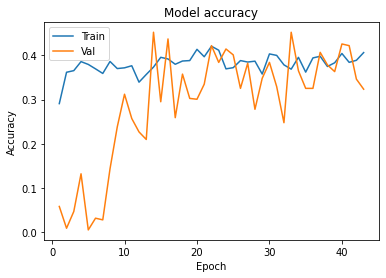

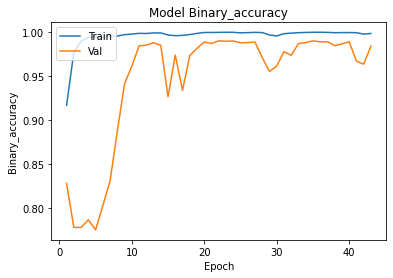

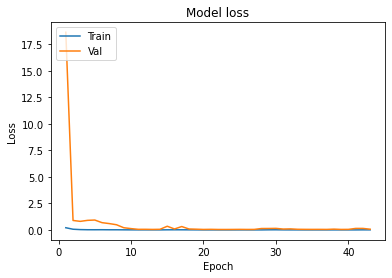

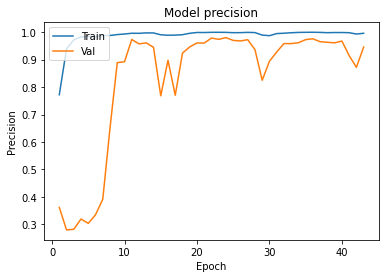

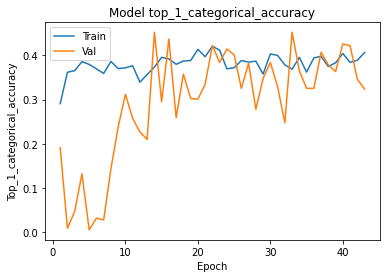

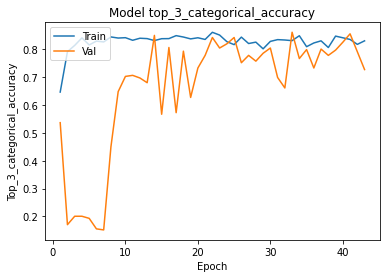

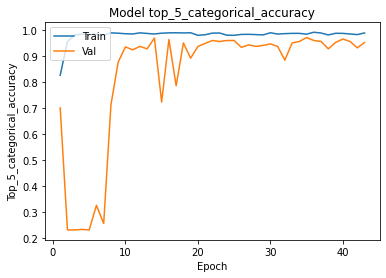

In [1]:
# https://kgptalkie.com/multi-label-image-classification-on-movies-poster-using-cnn/
!pip3 install tensorflowjs

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow import keras
import tensorflowjs as tfjs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import datetime
from google.colab import drive
import zipfile
import gc
from IPython import get_ipython
from skimage.util import random_noise
import cv2
from operator import itemgetter

print(tf.__version__)



RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'binary_crossentropy'
img_width = 256
img_height = 256
EPOCH = 100
BATCH_SIZE = 32
version= 'Golden'
classes =[]

def loadData(img_width,img_height,pathLabelConfig,pathImages):

    data = pd.read_csv(pathLabelConfig)
    print('data.head():' , data.head())

    info = data.drop(data.columns[4:],axis=1)
    print('info.head():' , info.head())
    print('info[id][1] : ', info['Id'][1])

    labels = data.drop(['Id', 'Genre','SampledType','Compose'], axis = 1)
    
    classes = data.columns[4:]
    print('classes:',classes)

    classnumber = classes.shape[0]
    print('classnumber:',classnumber)

    del data 
    gc.collect()
    
    images = []

    dsize = (img_width, img_height)

    for i in tqdm(range(info.shape[0])):

      path = os.path.join(pathImages, info['Id'][i] + '.jpg')

      img = cv2.imread(path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, dsize)

      if info['SampledType'][i] == 'O' :
        # Add salt-and-pepper noise to the image.
        img = random_noise(img, mode='s&p',amount=0.001)
  
        # The above function returns a floating-point image
        # on the range [0, 1], thus we changed it to 'uint8'
        # and from [0,255]
        img = np.array(255*img, dtype = 'uint8')

      # convert to numpy array
      img = image.img_to_array(img)
      img = img / 255.0
      images.append(img)

    del info 

    labels = labels.to_numpy()
    images = np.array(images)
    print('images.shape :' ,images.shape)
    print('labels.shape : ',labels.shape)
    gc.collect()

    return images,labels,classes,classnumber


def createModel(output_number):
    #Still not talking about our train/test data or any pre-processing.

    model = Sequential()

    # 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
    # NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
    model.add(tf.keras.applications.ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights ='imagenet'))

    # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
    model.add(Dense(output_number, activation = DENSE_LAYER_ACTIVATION))

    # Say not to train first layer (ResNet) model as it is already trained
    model.layers[0].trainable = True

    model.summary()
    return model

def plot_learningCurve(history, epoch , historyFolder):
  # Plot training & validation accuracy values
  epoch_range = range(1, len(history.history['accuracy']) + 1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig(os.path.join(historyFolder, 'accuracy.png'))
  plt.show()


  # Plot training & validation binary_accuracy values
  # epoch_range = range(1, epoch + 1)
  plt.plot(epoch_range, history.history['binary_accuracy'])
  plt.plot(epoch_range, history.history['val_binary_accuracy'])
  plt.title('Model Binary_accuracy')
  plt.ylabel('Binary_accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig(os.path.join(historyFolder, 'binary_accuracy.png'))
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig(os.path.join(historyFolder, 'loss.png'))
  plt.show()

  # Plot training & validation precision values
  plt.plot(epoch_range, history.history['precision'])
  plt.plot(epoch_range, history.history['val_precision'])
  plt.title('Model precision')
  plt.ylabel('Precision')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig(os.path.join(historyFolder, 'precision.png'))
  plt.show()

  # Plot training & validation top_1_categorical_accuracy values
  plt.plot(epoch_range, history.history['top_1_categorical_accuracy'])
  plt.plot(epoch_range, history.history['val_top_1_categorical_accuracy'])
  plt.title('Model top_1_categorical_accuracy')
  plt.ylabel('Top_1_categorical_accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig(os.path.join(historyFolder, 'top_1_categorical_accuracy.png'))
  plt.show()

  # Plot training & validation top_3_categorical_accuracy values
  plt.plot(epoch_range, history.history['top_3_categorical_accuracy'])
  plt.plot(epoch_range, history.history['val_top_3_categorical_accuracy'])
  plt.title('Model top_3_categorical_accuracy')
  plt.ylabel('Top_3_categorical_accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig(os.path.join(historyFolder, 'top_3_categorical_accuracy.png'))
  plt.show()

  # Plot training & validation top_5_categorical_accuracy values
  plt.plot(epoch_range, history.history['top_5_categorical_accuracy'])
  plt.plot(epoch_range, history.history['val_top_5_categorical_accuracy'])
  plt.title('Model top_5_categorical_accuracy')
  plt.ylabel('Top_5_categorical_accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.savefig(os.path.join(historyFolder, 'top_5_categorical_accuracy.png'))
  plt.show()
  



def saveHistory(history,histotyFileName):
  # convert the history.history dict to a pandas DataFrame:
  hist_df = pd.DataFrame(history.history) 
  hist_csv_file = histotyFileName
  with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

def run(datasetname):

    if 'google.colab' in str(get_ipython()):
        # print('Running on CoLab')    
        # drive.mount('/content/drive/')
        driveDir = 'drive/MyDrive/LocalDrive'
    else:
        print('Not running on CoLab')
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
        driveDir = 'D:/Data/SistemiDigitaliExamProject'


    print('driveDir :' + driveDir)
    # folder for dataset
    versionDir = os.path.join(driveDir, version)

    # folder per Dataset
    datasetDir = os.path.join(versionDir, 'Dataset')

    # folder per images
    imagesRootDir = os.path.join(datasetDir, 'Images')

    # folder per images for year
    imagesDir = os.path.join(imagesRootDir, datasetName)

    if 'google.colab' in str(get_ipython()):
        imagesZipFile = os.path.join(datasetDir, 'Images/' + datasetName + '.zip')
        # imagesZipFile ='https://raw.githubusercontent.com/AlmaMaterStudiorum/MoviePosterDataset/main/Images/' + datasetname +  '.zip'

        # on Colab folder per images
        imagesRootColabDir=os.path.join(datasetDir, '/ColabImages')

        # folder per images for year
        imagesDir = os.path.join(imagesRootColabDir, datasetName)

        zip_ref = zipfile.ZipFile(imagesZipFile, 'r')
        zip_ref.extractall(imagesRootColabDir)
        zip_ref.close()


    # sessionOptimizer='adam' # 'sgd'
    sessionOptimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    sessionName = datasetName + '_' + str(img_width) + '_' + str(img_height) + '_' + str(EPOCH)

    # time
    timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print('timestr:' + timestr)

    # name
    name = 'movie_' + sessionName + '_' + timestr #
    print('name:' + name)
   
    #FOLDER



    # folder per checkpoint e model
    runningDir = os.path.join(versionDir, 'Running')

    # folder per checkpoint
    checkpointsDir = os.path.join(runningDir, 'checkpoints')

    # session checkpoint file
    sessionCheckpointFile = os.path.join(checkpointsDir, name + '/cp-{epoch:04d}.ckpt')
    print('sessionCheckpointFile:' + sessionCheckpointFile)

    # sessione checkpont dir
    sessionCheckpointDir = os.path.dirname(sessionCheckpointFile)
    print('sessionCheckpointDir:' + sessionCheckpointDir)

    # crea sessione checkpont dir
    os.makedirs(sessionCheckpointDir)
    print('mkdir:' + format(sessionCheckpointDir))



    # folder per models
    modelsDir = os.path.join(runningDir, 'models')

    # crea session model dir
    sessionModelDir = os.path.join(modelsDir, name)
    print('sessionModelDir:' + sessionModelDir)

    # crea sessione model dir
    os.makedirs(sessionModelDir)
    print('mkdir:' + format(sessionModelDir))

    # crea session model file name
    sessionModelFile = os.path.join(sessionModelDir, 'model.h5')
    print('sessionModelFile:' + sessionModelFile)

    # crea session model file name
    sessionBestModelFile = os.path.join(sessionModelDir, datasetName + '.h5')
    print('sessionBestModelFile:' + sessionBestModelFile)

    # folder per history
    # historysDir = os.path.join(runningDir, 'historys')
    historysDir = sessionModelDir

    # session history file
    sessionHistoryFile = os.path.join(sessionModelDir, 'history.csv')
    print('sessionHistoryFile:' + sessionHistoryFile)

    # session tensorboard_logs dir
    sessionLogDir = os.path.join(runningDir, 'tensorboard_logs/' + name) 

    # crea session model tensorflow.js directory
    sessionModelTensorflowJsDir = os.path.join(sessionModelDir, 'TfJs')
    print('sessionModelTensorflowJsDir:' + sessionModelTensorflowJsDir)



    # folder per labels
    labelsDir = os.path.join(datasetDir, 'Labels')

    # fullpath per labelconfig
    labelConfig = os.path.join(labelsDir,  datasetName + '.O.csv')


    imagesOriginal , labelsOriginal ,classes,outputNumber = loadData(img_width,img_height,labelConfig,imagesDir)
    gc.collect()

    imagesToTrain, imagesToTest, labelsToTrain, labelsToTest = train_test_split(imagesOriginal, labelsOriginal,shuffle=True, random_state = 0, test_size = 0.15)
    print('imagesToTrain.shape : ',imagesToTrain.shape)
    print('labelsToTrain.shape : ',labelsToTrain.shape)
    print('imagesToTest.shape : ',imagesToTest.shape)
    print('labelsToTest.shape : ',labelsToTest.shape)
    del imagesOriginal 
    del labelsOriginal 
    gc.collect()



    # MODEL
    model = createModel(outputNumber)
    model.compile(optimizer=sessionOptimizer, 
                  loss = OBJECTIVE_FUNCTION, 
                  metrics=['accuracy',
                           'binary_accuracy',
                           tf.keras.metrics.TopKCategoricalAccuracy( k=1, name="top_1_categorical_accuracy", dtype=None),
                           tf.keras.metrics.TopKCategoricalAccuracy( k=3, name="top_3_categorical_accuracy", dtype=None),
                           tf.keras.metrics.TopKCategoricalAccuracy( k=5, name="top_5_categorical_accuracy", dtype=None),
                           tf.keras.metrics.TruePositives(name='truepositive'),
                           tf.keras.metrics.TrueNegatives(name='truenegative'),
                           tf.keras.metrics.FalsePositives(name='falsepositive'),
                           tf.keras.metrics.FalseNegatives(name='falsenegative'),
                           tf.keras.metrics.Precision(name='precision')])

    tensorboard_callback = TensorBoard(log_dir=sessionLogDir,histogram_freq=1)

    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,verbose=1)
    modelCheckpoint_callback = ModelCheckpoint(sessionBestModelFile, 
                                               monitor='val_binary_accuracy', 
                                               mode='max',
                                               save_best_only=True,
                                               save_weights_only=False, 
                                               verbose=1)

    history = model.fit(imagesToTrain, 
                        labelsToTrain, 
                        epochs=EPOCH, 
                        batch_size=BATCH_SIZE,
                        validation_data=(imagesToTest, labelsToTest),
                        callbacks=[earlystopping_callback,modelCheckpoint_callback,tensorboard_callback])

    # convert h5 to TsJs
    modelToJs = keras.models.load_model(sessionBestModelFile)
    tfjs.converters.save_keras_model(modelToJs, sessionModelTensorflowJsDir)

    # save metrics : hystory and plotted images of the metrics( metric / val_metric)
    saveHistory(history,sessionHistoryFile)
    plot_learningCurve(history, EPOCH, historysDir )


    # evaluate the model
    # score = model.evaluate(imagesToTrain[50], labelsToTrain[50], verbose=0)
    # imageTest = imagesToTrain[50]
    # imageTest = imageTest.reshape(1,128,128,3)
    # labelTest = labelsToTrain[50]
    # print(imageTest)
    # y_prob = model.predict(imageTest)
    # max = y_prob.shape[1]
    # table=[]
    # for i in range(max):
    #     element=(i,classes[i],y_prob[0][i],labelTest[i])
    #     print(element)
    #     table.append(element)
    
    # topAll = sorted(table, key = itemgetter(2), reverse=True)
    # print('Inizio Predizione ----------------')
    # for i in range(max):
    #   print(topAll[i])
    # print('Fine Predizione ----------------')

    

# INIZIO SCRIPT
# variabili di configurazione

# datasetName = 'Year2000'

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')    
    drive.mount('/content/drive/')


# run(datasetName)
datasetName = 'Year2019' 
run(datasetName)

# for x in range(2011,2020,1):
#     datasetName = 'Year' + str(x)
#     run(datasetName)

